# COMP90051 Project 2

In [1]:
# Do not edit. These are the only imports permitted.
import numpy as np
from abc import ABC, abstractmethod
from sklearn.tree import DecisionTreeClassifier   # for Task 4
from sklearn.base import clone                    # optional for Task 4
import matplotlib.pyplot as plt                   # for Task 5
from sklearn.metrics.pairwise import rbf_kernel   # for Task 6

In [2]:
class MAB(ABC):
    """Base class for a contextual multi-armed bandit (MAB)
    
    Parameters
    ----------
    n_arms : int
        Number of arms.
    """
    def __init__(self, n_arms):
        if not np.issubdtype(type(n_arms), np.integer):
            raise TypeError("`n_arms` must be an integer")
        if not n_arms >= 0:
            raise ValueError("`n_arms` must be non-negative")
        self.n_arms = n_arms
        # your code here (if you like)
        
    @abstractmethod
    def play(self, context):
        """Play a round
        
        Parameters
        ----------        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors presented to the MAB. The 0-th 
            axis indexes the arms, and the 1-st axis indexes the features.
            Non-contextual bandits accept a context of None.
        
        Returns
        -------
        arm : int
            Integer index of the arm played this round. Should be in the set 
            {0, ..., n_arms - 1}.
        """
        # your code here (if you like)

        
    @abstractmethod
    def update(self, arm, reward, context):
        """Update the internal state of the MAB after a play
        
        Parameters
        ----------
        arm : int
            Integer index of the played arm in the set {0, ..., n_arms - 1}.
        
        reward : float
            Reward received from the arm.
        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors that was presented to the MAB. The 
            0-th axis indexes the arms, and the 1-st axis indexes the 
            features. Non-contextual bandits accept a context of None. 
        """
        # your code here (if you like)
        
        

In [3]:
# Define global functions here, if required


## 1. Implement ε-greedy and UCB MABs

In [4]:
class EpsGreedy(MAB):
    """Epsilon-Greedy multi-armed bandit

    Parameters
    ----------
    n_arms : int
        Number of arms

    epsilon : float
        Explore probability. Must be in the interval [0, 1].

    Q0 : float, default=np.inf
        Initial value for the arms.
    """
    def __init__(self, n_arms, epsilon, Q0=np.inf):
        # check the input structure
        assert type(n_arms) == int, "the type of arms must be integer"
        assert n_arms > 0, "the number of arms must be positive"
        assert type(epsilon) == float, "the type of epsilon must be float"
        assert epsilon >=0 and epsilon <=1, "epsilon must in the interval [0,1]"
        assert type(Q0) == float, "the type of Q0 must be float"
        
        super().__init__(n_arms)
        # your code here
        
        self.epsilon = epsilon
        self.Q0 = Q0
        # store estimate reward for each arm
        self.val_Q = [Q0 for i in range(n_arms)]
        # count the number of times we play each arm
        self.times = np.zeros(n_arms)
        
    def play(self, context=None):
        super().play(context)
        # your code here
        
        # exploration when random number is smaller than epsilon
        random_num = np.random.uniform(0,1) # random number generator
        if random_num < self.epsilon:
            choseArm = np.random.randint(self.n_arms) 
            return choseArm
        else:
        # exploitation when random number is larger than epsilon
        # create a list to store the max values
            armList = []
            values = self.val_Q
            for index, value in enumerate(values):# exploitation
                if value == max(values):
                    armList.append(index)
            # randomly choose one when the values of arms are the same
            choseArm = np.random.choice(armList)
            return choseArm
    
    def update(self, arm, reward, context=None):
        super().update(arm, reward, context)
        # your code here
        curr_val_Q = self.val_Q[arm]
        if curr_val_Q == np.inf:
            curr_val_Q = 0
        self.times[arm] += 1
        curr_count = self.times[arm]
        self.val_Q[arm] = (curr_val_Q * (curr_count - 1) + reward) / curr_count

In [5]:
class UCB(MAB):
    """Upper Confidence Bound (UCB) multi-armed bandit

    Parameters
    ----------
    n_arms : int
        Number of arms.

    rho : float
        Positive real explore-exploit parameter.

    Q0 : float, default=np.inf
        Initial value for the arms.
    """
    def __init__(self, n_arms, rho, Q0=np.inf):
        super().__init__(n_arms)
        # your code here
        # check the input structure
        assert type(n_arms) == int, "the type of arms must be integer"
        assert n_arms > 0, "the number of arms must be positive"
        assert type(rho) == float, "the type of epsilon must be float"
        assert rho > 0, "rho must be positive"
        assert type(Q0) == float, "the type of Q0 must be float"
        
        self.Q0 = Q0
        self.rho = rho
        # initialise the number of times we play for each arm
        self.times = np.zeros(n_arms)
        # initialise arms' values
        self.val_Q = [Q0 for i in range(n_arms)]
        # initialise the average value for each arm
        self.average_val = [Q0 for i in range(n_arms)]
        # initialise the number of rounds we play
        self.n_rounds = 0
        
    def play(self, context=None):
        super().play(context)
        # your code here
        
        armList = []
        values = self.val_Q
        # choose the best arm
        for index, value in enumerate(values):
            if value == max(values):
                armList.append(index)
        # randomly choose one when the values of arms are the same  
        choseArm = np.random.choice(armList)
        return choseArm 

    def update(self, arm, reward, context=None):
        super().update(arm, reward, context)
        # your code here
        
        self.n_rounds += 1 # update rounds
        # extract current value of the selected arm
        curr_times = self.times[arm]
        curr_average = self.average_val[arm]
        if curr_average == np.inf:
            curr_average = 0
        self.times[arm] += 1
        curr_times = self.times[arm] 
        #update average value of each arm
        self.average_val[arm] = (curr_average * (curr_times - 1) + reward) / curr_times
        for i in range(self.n_arms):
            mu = self.average_val[i]
            if mu == np.inf:
                mu = 0
            else:
                self.val_Q[i] = mu + np.sqrt(self.rho*np.log(self.n_rounds)/ self.times[i])

## 2. Implement off-policy evaluation

In [6]:
def offlineEvaluate(mab, arms, rewards, contexts, n_rounds=800):
    """Offline evaluation of a multi-armed bandit
    
    Parameters
    ----------
    mab : instance of MAB
        MAB to evaluate.
    
    arms : integer numpy.ndarray, shape (n_events,) 
        Array containing the history of pulled arms, represented as integer 
        indices in the set {0, ..., mab.n_arms}
    
    rewards : float numpy.ndarray, shape (n_events,)
        Array containing the history of rewards.
    
    contexts : float numpy.ndarray, shape (n_events, n_arms, n_dims)
        Array containing the history of contexts presented to the arms. 
        The 0-th axis indexes the events in the history, the 1-st axis 
        indexes the arms and the 2-nd axis indexed the features.
        
    n_rounds : int, default=None
        Number of matching events to evaluate the MAB on. If None, 
        continue evaluating until the historical events are exhausted.
    
    Returns
    -------
    out : float numpy.ndarray
        Rewards for the matching events.
    """
    # your code here
    # make sure the input structure is consistent with the requirement
    assert n_rounds > 0, "the number of rounds must be more than 0"
    assert type(n_rounds) == int, "the type of rounds must be integer"
    assert len(arms) == len(rewards), "the length of arms must be equal to the length of rewards"
    assert len(arms) == len(contexts), "the length of arms must be equal to the length of contexts"
    assert arms.ndim == 1, "arm must be 1D numpy array"
    assert rewards.ndim == 1, "rewards must be 1D numpy array"
    assert contexts.ndim == 3, "contexts must be 3D numpy array"
    
    good_rewards = []
    index = 0
    for i in range(len(arms)):
        # make sure the matched number doesn't go over the round number
        if n_rounds is not None and index >= n_rounds:
            break
        new_arm = mab.play(contexts[i])
        # when policy are match
        if new_arm == arms[i]:
           # retain the event, and store the corresponding reward to the list
            mab.update(new_arm, rewards[i], contexts[i])
            good_rewards.append(rewards[i])
            index += 1
    return np.array(good_rewards)
        
        

In [7]:
# load dataset here
data = np.genfromtxt('dataset.txt')
arms = data[:,0].astype(int)
rewards = data[:,1].astype(float)
contexts = data[:,2:]
contexts = contexts.reshape(contexts.shape[0], 10, 10).astype(float)

In [8]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.25875


In [9]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.17375


## 3. Implement LinUCB contextual MAB

In [10]:
# todo: consider the shape of contexts and re-run it 
class LinUCB(MAB):

    """Contextual multi-armed bandit (LinUCB)

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    alpha : float
        Positive real explore-exploit parameter.
    """
    def __init__(self, n_arms, n_dims, alpha):
        super().__init__(n_arms)
        # your code here
        
        # check the input structure
        assert type(n_arms) == int, "the type of arms must be integer"
        assert n_arms > 0, "the number of input arms must be positive"
        assert type(n_dims) == int, "the type of dimensions must be integer"
        assert n_dims > 0, "the number of dimension must be positive"
        assert type(alpha) == float, "the type of alpha parameter must be float"
        assert alpha > 0, "alpha must be positive"
        
        self.n_arms = n_arms
        self.n_dims = n_dims
        self.alpha = alpha
        self.Am = {}
        self.bm = {}
        self.p = np.zeros(n_arms)
        # initialize matrix and vector list for every arms
        for i in range(n_arms):
            self.Am[i] = np.identity(n_dims)  # d-dimensional identity matrix
            self.bm[i] = np.zeros((n_dims, 1))# d-dimensional zero vector 

        
    def play(self, context):
        super().play(context)
        # your code here
        n_arms = self.n_arms
        # calculate p value for each arm
        p = np.empty(self.n_arms)
        for arm in range(n_arms):
            Xa_t = context[arm]
            Xa = np.transpose([Xa_t])
            theta = np.dot(np.linalg.inv(self.Am[arm]), self.bm[arm])
            p1 = np.dot(Xa_t, theta)
            p2 = self.alpha * np.sqrt(np.dot(np.dot(Xa_t, np.linalg.inv(self.Am[arm])), Xa))
            self.p[arm] =  p1 + p2
            
        # find the arm which has the max p and randomly break the tie
        armList = []
        for index, value in enumerate(self.p):
            if value == max(self.p):
                armList.append(index)
        choseArm = int(np.random.choice(armList))
        return choseArm
    
    
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        # your code here
        target = np.array(context[arm])
        target = target[np.newaxis,:]
        target_trans = np.transpose([context[arm]])
        # update Am and bm
        self.Am[arm] += np.dot(target_trans, target)
        self.bm[arm] += reward * np.transpose([context[arm]])


In [11]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.53


## 4. Implement TreeBootstrap contextual MAB

In [12]:
class TreeBootstrap(MAB):
    """Contextual Thompson sampled multi-armed bandit (TreeBootstrap)

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    tree : instance of sklearn.tree.DecisionTreeClassifier, optional
        Decision tree to use for predicting the expected future reward. 
        Defaults to sklearn.tree.DecisionTreeClassifier().
    """
    def __init__(self, n_arms, n_dims, tree=DecisionTreeClassifier()):
        
        super().__init__(n_arms)
        # your code here
        # check the input structure
        assert type(n_arms) == int, "the type of arms must be integer"
        assert n_arms > 0, "the number of input arms must be positive"
        assert type(n_dims) == int, "the type of dimensions must be integer"
        assert n_dims > 0, "the number of dimension must be positive"

        
        self.n_arms = n_arms
        self.n_dims = n_dims
        self.tree = tree
        self.D = {} # D represents a set of context and reward pairs
        for i in range(n_arms):
            self.D[i] = set()
        self.phat = np.zeros(n_arms)
        
    def play(self, context):
        super().play(context)
        # your code here
        n_arms = self.n_arms
        n_dims = self.n_dims
        # start for loop
        for i in range(n_arms):
            X = np.empty((0, n_dims))
            y = np.array([])
            # if |D(t,a)| is empty, predict 1 for any input
            if len(self.D[i]) == 0:
                X = [[0]]
                y = [1]
                self.tree = self.tree.fit(X, y)
                self.phat[i] = self.tree.predict(X)
            else:
                # if |D(t,a)| is not empty, sample bootstrap D (t,a) from original D_origin
                list_D = list(self.D[i])
                index = np.random.randint(0, len(list_D), size = len(list_D))
                for idx in index:
                    X = np.append(X, np.array([list_D[idx][0]]), axis = 0)
                    y = np.append(y, list_D[idx][1])
                self.tree = self.tree.fit(X, y)
                
                if len(self.tree.predict_proba([context[i]])[0]) == 1:
                    self.phat[i] = self.tree.predict([context[i]])[0]
                else:
                    self.phat[i] = self.tree.predict_proba([context[i]])[0][1]
        # end for loop
        
        # choose arm that maximise the probability and randomly break the tie
        armList = []
        for index, value in enumerate(self.phat):
            if value == max(self.phat):
                armList.append(index)
        choseArm = int(np.random.choice(armList))
        return choseArm
            
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        # your code here
        if len(self.D[arm]) == 0:
            self.D[arm].add((tuple(context[arm]), 0))
            self.D[arm].add((tuple(context[arm]), 1))
        else:
            self.D[arm].add((tuple(context[arm]), reward))

In [14]:
mab = TreeBootstrap(10, 10)
results_TreeBootstrap = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('TreeBootstrap average reward', np.mean(results_TreeBootstrap))

TreeBootstrap average reward 0.6025


## 5. Evaluation and hyperparameter tuning for LinUCB
### 5.A.

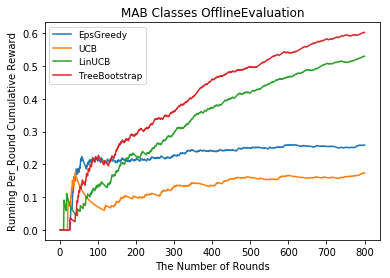

In [15]:
# your code here
# calculate the cumulative reward for each round

# this chunk represents EpsGreedy class
cumsum_eps = []
eps_round_sum = 0
for i in range(len(results_EpsGreedy)):
    eps_round_sum += results_EpsGreedy[i]
    cumsum_eps.append(eps_round_sum/(i+1))

# this chunk represents UCB class
cumsum_UCB = []
UCB_round_sum = 0
for i in range(len(results_UCB)):
    UCB_round_sum += results_UCB[i]
    cumsum_UCB.append(UCB_round_sum/(i+1))

# this chunk represents LinUCB class    
cumsum_Lin = []
Lin_round_sum = 0
for i in range(len(results_LinUCB)):
    Lin_round_sum += results_LinUCB[i]
    cumsum_Lin.append(Lin_round_sum/(i+1))
    
# this chunk represents TreeBootstrap class
cumsum_bootstrap = []
tree_round_sum = 0
for i in range(len(results_TreeBootstrap)):
    tree_round_sum += results_TreeBootstrap[i]
    cumsum_bootstrap.append(tree_round_sum/(i+1))
    
total_rounds = np.arange(1,801)
plt.plot(total_rounds, cumsum_eps, label = 'EpsGreedy')
plt.plot(total_rounds, cumsum_UCB, label = 'UCB')
plt.plot(total_rounds, cumsum_Lin, label = 'LinUCB')
plt.plot(total_rounds, cumsum_bootstrap, label = 'TreeBootstrap')

plt.legend(loc=2, prop = {'size': 9})
plt.xlabel("The Number of Rounds")
plt.ylabel("Running Per_Round Cumulative Reward")
plt.title("MAB Classes OfflineEvaluation")
plt.show()

### 5.B.

In [16]:
# your code here
# aim: tune alpha hyperparamter and return the alpha which gives the highest reward of LinUCB
alpha_list = []
value = []
alpha_dict = {}
# 
chooseRange = np.arange(0.1, 2.1, 0.1).astype(float)
for i in chooseRange:
    alpha_list.append(round(i,2))
    
for alpha in alpha_list:
    alpha = float(alpha)
    rounds = 3
    curr_round = 1
    # take the average reward of three rounds
    while curr_round <= rounds:
        mab = LinUCB(10, 10, alpha)
        evaluation = offlineEvaluate(mab, arms, rewards, contexts, 800)
        value.append(evaluation)
        curr_round += 1
    mean_value = np.mean(value)
    alpha_dict[alpha] = mean_value
    
best_alpha = max(alpha_dict, key=alpha_dict.get)
print("The Best Alpha between 0.1 and 2 (step=0.1) is: {}".format(best_alpha))

The Best Alpha between 0.1 and 2 (step=0.1) is: 0.1


## 6. Implement KernelUCB contextual MAB

In [ ]:
class KernelUCB(MAB):
    """Kernelised contextual multi-armed bandit (Kernelised LinUCB)
    
    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    gamma : float
        Positive real explore-exploit parameter.
    
    eta : float
        Positive real explore-exploit parameter.
    
    kern : callable
        A kernel function from sklearn.metrics.pairwise.
    """
    def __init__(self, n_arms, n_dims, gamma, eta, kern):
        super().__init__(n_arms)
        # your code here
        
        # check the input structure
        assert type(n_arms) == int, "the type of arms must be integer"
        assert n_arms > 0, "the number of input arms must be positive"
        assert type(n_dims) == int, "the type of dimensions must be integer"
        assert n_dims > 0, "the number of dimension must be positive"
        assert type(gamma) == float, "the type pf alpha parameter must be float"
        assert gamma > 0, "alpha must be positive"
        assert type(eta) == float, "the type of eta paramter must be float"
        assert eta > 0, "eta must be positive"
        
        self.n_arms = n_arms
        self.n_dims = n_dims
        self.gamma = gamma
        self.eta = eta
        self.kern = kern
        self.t = 0
        self.u = {}
        self.Kinv = np.empty(0)
        self.new_context = np.zeros((0, n_dims))
        
    def play(self, context):
        super().play(context)
        # your code here
        t = self.t
        n_arms = self.n_arms
        # when round = 1, intialise a list with first value is 1
        if t == 1:
            List = np.zeros(n_arms)
            List[0] = 1
            self.u[t] = np.transpose(List)
        else:
            for a in range(n_arms):
                k = self.kern(context, context)
                kx = self.kern(context, self.new_context) # what is t
                kx_trans = kx.T
                K = np.dot(context[a], context[a].T)
                K_inv = np.linalg.inv(K)
                sigma = np.sqrt(k - np.dot(np.dot(kx_trans, K_inv), kx))
                u[a] = np.dot(kx_trans, K_inv) + self.eta/np.sqrt(self.gamma) * sigma 
               # what is yt
        # choose arm and randomly break the tie   
        armList = []
        for index, value in enumerate(self.u):
            if value == max(self.u):
                armList.append(index)
        choseArm = int(np.random.choice(armList))
        return choseArm
        
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        # your code here
        self.t += 1
        if self.t == 1 :
            self.Kinv = 1/(self.kern(context, context) + self.gamma)
        else:
            b = kx[arm]
            b_Kinv = np.dot(b, self.Kinv)
            Kinv_b = np.dot(self.Kinv, b)
            b_new = np.dot(b, self.Kinv)
            K22 = 1 /(self.kern(context, context) + self.gamma - np.dot(b.T, np.dot(self.Kinv,b)))
            K11 = self.Kinv + np.dot(K22, self.Kinv), b
            K12 = -K22*Kinv_b
            K21 = -K22*b.T*self.Kinv
            self.Kinv = np.block([[K11, K12], [K21, K22]])
            
        
        

In [ ]:
mab = KernelUCB(10, 10, 1.0, 0.1, rbf_kernel)
results_KernelUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('KernelUCB average reward', np.mean(results_KernelUCB))

In [ ]:
# your plotting code here
cumsum_kernel = []
kernel_round_sum = 0
for i in range(len(results_KernelUCB)):
    kernel_round_sum += results_KernelUCB[i]
    cumsum_kernel.append(kernel_round_sum/(i+1))
    
total_rounds = np.arange(1,801)
plt.plot(total_rounds, cumsum_kernel, label = 'KernelUCB')

plt.legend(loc=2)
plt.xlabel("The Number of Rounds")
plt.ylabel("Running Per_Round Cumulative Reward")
plt.title("KernelUCB OfflineEvaluation")
plt.show()